In [1]:
from comet_ml import Experiment

experiment = Experiment(
    api_key="Qta9GieqkZxXGHSrnJrg55z3O",
    project_name="vision-apnea",
    workspace="martaferpoy",
)
experiment.set_name("ResNet18")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Users\\GIB\\Documents\\Marta\\notebooks\\img' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/martaferpoy/vision-apnea/0832810b2848499bb63216e19d2d41f3



In [2]:
import numpy as np 
import pandas as pd
from statistics import mean
import math
import scipy.io as sio
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
import PIL
from PIL import Image
import glob

In [3]:
hiperparametros = {
    'epocas' : 40,
    'lr' : 0.001,
    'batch_size' : 16,
    'seed' : 56389856
}

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [5]:
torch.cuda.is_available()

True

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [7]:
device

device(type='cuda')

## Dataset

In [8]:
ruta_thorres_train = 'C:/Users/GIB/Documents/Marta/img/img/train/img_thorres/'
ruta_abdores_train = 'C:/Users/GIB/Documents/Marta/img/img/train/img_abdores/'
ruta_labels_train = 'C:/Users/GIB/Documents/Marta/img/img/train/labels_img/'

ruta_thorres_val = 'C:/Users/GIB/Documents/Marta/img/img/validation/img_thorres/'
ruta_abdores_val = 'C:/Users/GIB/Documents/Marta/img/img/validation/img_abdores/'
ruta_labels_val = 'C:/Users/GIB/Documents/Marta/img/img/validation/labels_img/'

In [9]:
imagenes_thorres_train = glob.glob('C:/Users/GIB/Documents/Marta/img/img/train/img_thorres/*')
imagenes_thorres_val = glob.glob('C:/Users/GIB/Documents/Marta/img/img/validation/img_thorres/*')

In [10]:
class MyDataset(Dataset):
    def __init__(self, x_thorres, ruta_abdores, ruta_labels) -> None:
        self.x_thorres = x_thorres  # ruta a imagenes
        self.ruta_abdores = ruta_abdores
        self.ruta_labels = ruta_labels


    def __getitem__(self, index):
        x_ind_thorres = self.x_thorres[index]

        # Extraer info de las imagenes
        individual = x_ind_thorres.split('\\')[-1].split('.')[0]
        individual_name = individual.split('_')[0]
        individual_fragment = int(individual.split('_')[1])
        
        # Cargar imagenes
        img_thorres = np.array(PIL.Image.open(x_ind_thorres))
        img_abdores = np.array(PIL.Image.open(self.ruta_abdores+individual+'.png'))
        
        # to torch
        img_thorres_t = torch.from_numpy(img_thorres/255).float()
        img_abdores_t = torch.from_numpy(img_abdores/255).float()
        
        # Etiqueta
        ruta_etiqueta_concreta = self.ruta_labels + individual_name + '_labels.mat'
        etiqueta = sio.loadmat(ruta_etiqueta_concreta).get('vec_all_events')[0][individual_fragment-1]
        
        # concatenar imagenes
        x_join = torch.cat([img_thorres_t, img_thorres_t], axis = 0)
        x_join = torch.moveaxis(x_join, -1, 0)
        
        
        y = torch.Tensor([etiqueta]).float()

        return x_join,y, individual.split('_')[0]

    def __len__(self):
        return len(self.x_thorres)

In [11]:
dataset = MyDataset(imagenes_thorres_train,ruta_abdores_train, ruta_labels_train)

In [12]:
dataset_val = MyDataset(imagenes_thorres_val,ruta_abdores_val, ruta_labels_val)

## Dataloader

In [13]:
dataloader = DataLoader(dataset, batch_size = hiperparametros['batch_size'], shuffle = True) 

In [14]:
dataloader_val = DataLoader(dataset_val, batch_size = hiperparametros['batch_size'], shuffle = True) 

## Model

In [15]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in C:\Users\GIB/.cache\torch\hub\pytorch_vision_v0.10.0


In [16]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)
model = model.to(device)

In [17]:
summary(model, input_size= (3,1312, 875))  

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            25

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            25

In [18]:
criterion = torch.nn.HuberLoss(reduction= "mean")
optimizer = torch.optim.Adam(model.parameters(), lr=hiperparametros['lr'])

In [19]:
def validate_loss_kappa_acc(val_loss, val_kappa, val_accuracy):
    model.eval()
    loss_medio_val = 0
    pasos_val = 0
  
    dict_patients_val = {}
    outputs_list_val = torch.empty(0).to(device)
    labels_list_val = torch.empty(0).to(device)
    names_list_val = ()

    with torch.no_grad():
        for data in dataloader_val:
            inputs, labels, names = data[0].to(device), data[1].to(device), data[2]
            outputs = model(inputs)
            loss_val = criterion(outputs, labels)
            loss_medio_val += loss_val.item()
            outputs_list_val = torch.cat((outputs_list_val, outputs))
            labels_list_val = torch.cat((labels_list_val, labels))
            names_list_val = names_list_val + names

            pasos_val += 1
      
    val_loss.append(loss_medio_val/pasos_val)
    experiment.log_metric('Loss validation',loss_medio_val/pasos_val)

    dict_patients_val = group_pacients(outputs_list_val.detach().to('cpu').numpy(), labels_list_val.detach().to('cpu').numpy(), names_list_val, dict_patients_val)

    kappa, accuracy = get_AHI_kappa_acc(dict_patients_val)

    val_kappa.append(kappa)
    val_accuracy.append(accuracy)
    
    experiment.log_metric('Kappa validation',kappa)
    experiment.log_metric('Accuracy validation',accuracy)
    
    return(val_loss, val_kappa, val_accuracy, loss_medio_val/pasos_val, kappa, accuracy, outputs_list_val, labels_list_val, names_list_val)

In [20]:
def group_pacients(output_batch, labels_batch, names_batch, dict_p):
    for i in range(output_batch.shape[0]):
        output = output_batch[i]; label = labels_batch[i]; name = names_batch[i]

        if name in [*dict_p]:
            dict_p[name].append([output, label])
        else:
            dict_p[name] = [[output, label]]

    return dict_p

In [21]:
def get_AHI_kappa_acc(dictionary):
    AHI_pred = []
    AHI_real = []
  
    for key in [*dictionary]:
        individual = dictionary[key]
        outputs_ind = [item[0] for item in individual]
        labels_ind = [item[1] for item in individual]

        AHI_pred.append(sum(outputs_ind)/len(outputs_ind)*3)
        AHI_real.append(sum(labels_ind)/len(labels_ind)*3)

    AHI_pred_disc = np.digitize(AHI_pred, bins = np.array([5,15,30]))
    AHI_real_disc = np.digitize(AHI_real, bins = np.array([5,15,30]))

    kappa = cohen_kappa_score(AHI_pred_disc, AHI_real_disc)

    accuracy = sum(AHI_pred_disc == AHI_real_disc).item()/len(AHI_real_disc)
    
    return kappa, accuracy

## Entrenamiento

In [22]:
loss_list =[]; validation_loss_list = []
kappa_list = []; validation_kappa_list = []
accuracy_list = []; validation_accuracy_list = []

loss_min = 10000000; kappa_max = -100000; accuracy_max = -1000
best_model = None; best_outputs = None; best_labels = None; best_names = None

tiempo = time.time()

for epoch in range(hiperparametros['epocas']):
    experiment.set_epoch(epoch)

    loss_medio = 0
    pasos = 0
    
    dict_patients = {}
    outputs_list = torch.empty(0).to(device)
    labels_list = torch.empty(0).to(device)
    names_list = ()

    # Bucle de entrenamiento
    for i,data in enumerate(dataloader, 0): 
        inputs, labels, names = data[0].to(device), data[1].to(device), data[2]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss_medio += loss.item()
        loss.backward() 
        optimizer.step() 

        outputs_list = torch.cat((outputs_list, outputs))
        labels_list = torch.cat((labels_list, labels))
        names_list = names_list + names
        
        pasos += 1

    print("Epoch = ", epoch)
    loss_list.append(loss_medio/pasos)
    
    
    
    experiment.log_metric('Loss train',loss_medio/pasos)

    dict_patients = group_pacients(outputs_list.detach().to('cpu').numpy(), labels_list.detach().to('cpu').numpy(), names_list, dict_patients)
    
    kappa, accuracy = get_AHI_kappa_acc(dict_patients)

    kappa_list.append(kappa)
    accuracy_list.append(accuracy)
    experiment.log_metric('Kappa train',kappa)
    experiment.log_metric('Accuracy train',accuracy)

    validation_loss_list, validation_kappa_list, validation_accuracy_list, loss_actual, kappa_actual, accuracy_actual, best_val_outputs, best_val_labels, best_val_names = validate_loss_kappa_acc(validation_loss_list, validation_kappa_list, validation_accuracy_list)

    # chequeo la metrica que tengo en esta epoca, y si es mejor que en epocas anteriores, guardo el modelo
    if(kappa_actual > kappa_max):
        loss_min = loss_actual
        kappa_max = kappa_actual
        accuracy_max = accuracy_actual
        best_model = copy.deepcopy(model)
        best_outputs = best_val_outputs
        best_labels = best_val_labels
        best_names = best_val_names
    
    model.train()
        
experiment.log_metric('Best loss validation', loss_min)
experiment.log_metric('Best kappa validation', kappa_max)
experiment.log_metric('Best accuracy validation', accuracy_max)

print("Time required: ", time.time() - tiempo)


Epoch =  0
Epoch =  1
Epoch =  2
Epoch =  3
Epoch =  4
Epoch =  5
Epoch =  6
Epoch =  7
Epoch =  8
Epoch =  9
Epoch =  10
Epoch =  11
Epoch =  12
Epoch =  13
Epoch =  14
Epoch =  15
Epoch =  16
Epoch =  17
Epoch =  18
Epoch =  19
Epoch =  20
Epoch =  21
Epoch =  22
Epoch =  23
Epoch =  24
Epoch =  25
Epoch =  26
Epoch =  27
Epoch =  28
Epoch =  29
Epoch =  30
Epoch =  31
Epoch =  32
Epoch =  33
Epoch =  34
Epoch =  35
Epoch =  36
Epoch =  37
Epoch =  38
Epoch =  39
Time required:  95983.84710931778


## Métricas

In [23]:
def get_AHI(dictionary):
    AHI_pred = []
    AHI_real = []
  
    for key in [*dictionary]:
        individual = dictionary[key]
        outputs_ind = [item[0] for item in individual]
        labels_ind = [item[1] for item in individual]

        AHI_pred.append(sum(outputs_ind)/len(outputs_ind)*3)
        AHI_real.append(sum(labels_ind)/len(labels_ind)*3)

    AHI_pred_disc = np.digitize(AHI_pred, bins = np.array([5,15,30]))
    AHI_real_disc = np.digitize(AHI_real, bins = np.array([5,15,30]))

    return AHI_pred_disc, AHI_real_disc

In [24]:
dict_best_patients = {}
dict_best_patients = group_pacients(best_outputs.detach().to('cpu').numpy(), best_labels.detach().to('cpu').numpy(), best_names, dict_best_patients)

In [25]:
AHI_pred_disc, AHI_real_disc = get_AHI(dict_best_patients)

In [26]:
def sens_especif_mat_conf_por_clases_inferiores(AHI_real_disc_, AHI_pred_disc_, clase):
    FP = sum(AHI_pred_disc_[AHI_real_disc_ > clase] <= clase)
    TP = sum(AHI_pred_disc_[AHI_real_disc_ <= clase] <= clase)
    TN = sum(AHI_pred_disc_[AHI_real_disc_ > clase] > clase)
    FN = sum(AHI_pred_disc_[AHI_real_disc_ <= clase] > clase)
    sensibilidad = TP/(TP + FN)
    especifidad = TN/(TN + FP)
    VPP = TP/(TP + FP)
    VPN = TN/(TN + FN)
    
    AHI_real_disc_clase = np.copy(AHI_real_disc_)
    AHI_real_disc_clase[AHI_real_disc_clase > clase] = 100
    AHI_real_disc_clase[AHI_real_disc_clase <= clase] = 0

    AHI_pred_disc_clase = np.copy(AHI_pred_disc_)
    AHI_pred_disc_clase[AHI_pred_disc_clase > clase] = 100
    AHI_pred_disc_clase[AHI_pred_disc_clase <= clase] = 0
    
    best_cfmatrix_val_clase = confusion_matrix(AHI_real_disc_clase, AHI_pred_disc_clase)
    
    group_counts = ["{0:0.0f}".format(value) for value in
                best_cfmatrix_val_clase.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         best_cfmatrix_val_clase.flatten()/np.sum(best_cfmatrix_val_clase)]

    labels = [f"{v1}\n{v2}\n" for v1, v2 in
              zip(group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    plt.rcdefaults()
    sns.set(font_scale=1.4)
    sns.set(rc = {'figure.figsize':(5,4)})

    sns.heatmap(best_cfmatrix_val_clase, annot=labels, annot_kws={"size": 14}, fmt='',  cmap='Blues')

    plt.title("\n Matriz de confusión")
    plt.xlabel("Estimado \n \n \n")
    plt.ylabel("\n \n Real")
    plt.show()
    plt.clf()
    plt.close()

    return sensibilidad, especifidad, VPP, VPN

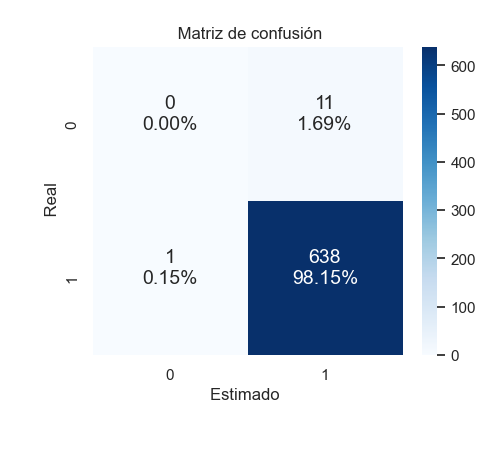

Sensibilidad =  0.0
Especifidad =  0.9984350547730829
VPP =  0.0
VPN =  0.9830508474576272


In [28]:
sensibilidad_0_inf, especifidad_0_inf, VPP_0_inf, VPN_0_inf = sens_especif_mat_conf_por_clases_inferiores(AHI_real_disc, AHI_pred_disc, 0)
print("Sensibilidad = ", sensibilidad_0_inf)
print("Especifidad = ", especifidad_0_inf)
print("VPP = ", VPP_0_inf)
print("VPN = ", VPN_0_inf)

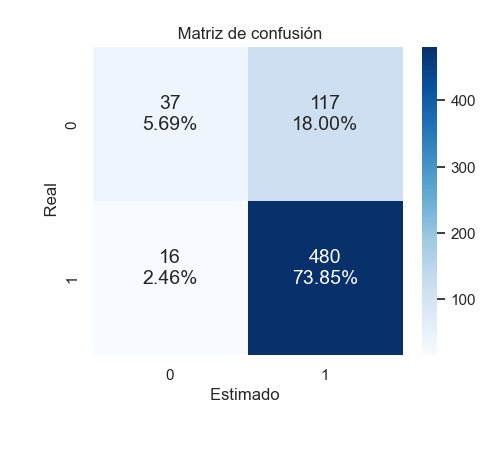

Sensibilidad =  0.24025974025974026
Especifidad =  0.967741935483871
VPP =  0.6981132075471698
VPN =  0.8040201005025126


In [29]:
sensibilidad_1_inf, especifidad_1_inf, VPP_1_inf, VPN_1_inf = sens_especif_mat_conf_por_clases_inferiores(AHI_real_disc, AHI_pred_disc, 1)
print("Sensibilidad = ", sensibilidad_1_inf)
print("Especifidad = ", especifidad_1_inf)
print("VPP = ", VPP_1_inf)
print("VPN = ", VPN_1_inf)

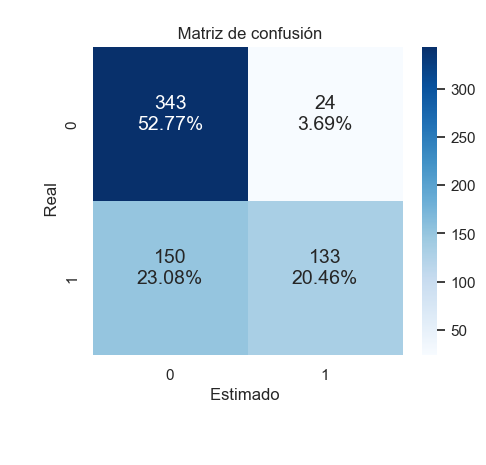

Sensibilidad =  0.9346049046321526
Especifidad =  0.46996466431095407
VPP =  0.6957403651115619
VPN =  0.8471337579617835


In [30]:
sensibilidad_2_inf, especifidad_2_inf, VPP_2_inf, VPN_2_inf = sens_especif_mat_conf_por_clases_inferiores(AHI_real_disc, AHI_pred_disc, 2)
print("Sensibilidad = ", sensibilidad_2_inf)
print("Especifidad = ", especifidad_2_inf)
print("VPP = ", VPP_2_inf)
print("VPN = ", VPN_2_inf)

In [31]:
best_cfmatrix_val = confusion_matrix(AHI_real_disc, AHI_pred_disc)
cf_mat_row = np.zeros((4,4))
for i in range(best_cfmatrix_val.shape[0]):
    cf_mat_row[i,:] = best_cfmatrix_val[i]/sum(best_cfmatrix_val[i])

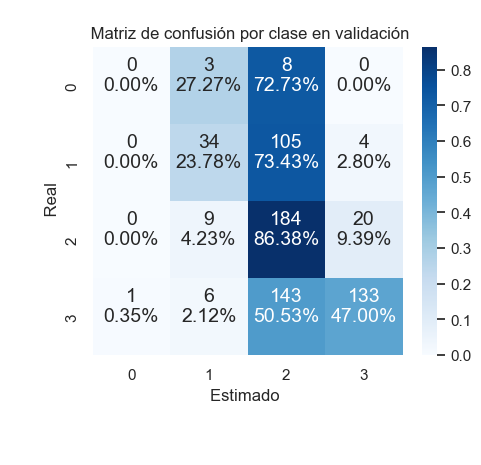

In [32]:
group_counts = ["{0:0.0f}".format(value) for value in
                best_cfmatrix_val.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_mat_row.flatten()]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(4,4)

plt.rcdefaults()
sns.set(font_scale=1.4)
sns.set(rc = {'figure.figsize':(5,4)})

sns.heatmap(cf_mat_row, annot=labels, annot_kws={"size": 14}, fmt='',  cmap='Blues')

plt.title("\n Matriz de confusión por clase en validación")
plt.xlabel("Estimado \n \n \n")
plt.ylabel("\n \n Real")
experiment.log_figure(figure_name='matriz_confusion_porcentaje', figure = plt)
plt.show()
plt.clf()
plt.close()

In [33]:
print('Loss en entrenamiento = ', loss_list[len(loss_list)-1])
print('Loss en validacion = ', validation_loss_list[len(validation_loss_list)-1])
print('Kappa en entrenamiento = ', kappa_list[len(kappa_list)-1])
print('Kappa en validacion = ', validation_kappa_list[len(validation_kappa_list)-1])
print('Accuracy en entrenamiento = ', accuracy_list[len(accuracy_list)-1])
print('Accuracy en validacion = ', validation_accuracy_list[len(validation_accuracy_list)-1])

Loss en entrenamiento =  2.1409170488733844
Loss en validacion =  6.0379475754063305
Kappa en entrenamiento =  0.7854000068424948
Kappa en validacion =  0.20249358165132403
Accuracy en entrenamiento =  0.8595009596928983
Accuracy en validacion =  0.4676923076923077


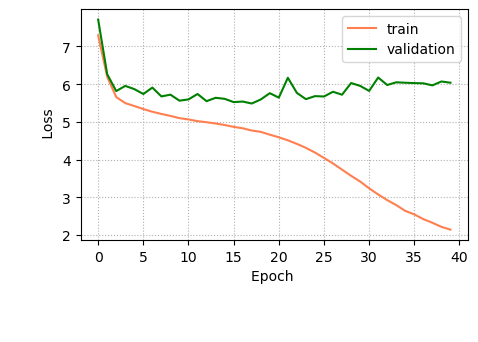

In [34]:
plt.rcdefaults()
plt.figure(figsize = (5,3))
plt.plot(loss_list, color = "coral", label = "train")
plt.plot(validation_loss_list, color = "green", label = "validation")
plt.xlabel('Epoch \n \n \n', color = 'black')
plt.ylabel('\n \n Loss', color = 'black')
plt.grid(linestyle = 'dotted')
plt.legend()
experiment.log_figure(figure_name='Loss_plot', figure = plt)
plt.show()
plt.clf()
plt.close()

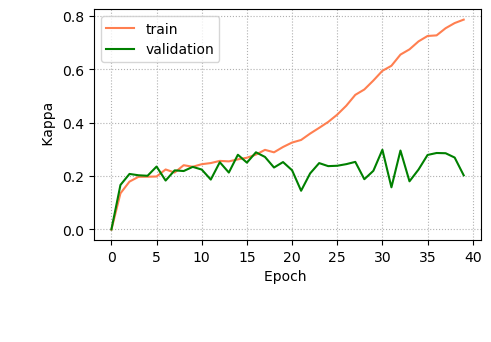

In [35]:
plt.rcdefaults()
plt.figure(figsize = (5,3))
plt.plot(kappa_list, color = "coral", label = "train")
plt.plot(validation_kappa_list, color = "green", label = "validation")
plt.xlabel('Epoch \n \n \n', color = 'black')
plt.ylabel('\n \n Kappa', color = 'black')
plt.grid(linestyle = 'dotted')
plt.legend()
experiment.log_figure(figure_name='Kappa_plot', figure = plt)
plt.show()
plt.clf()
plt.close()

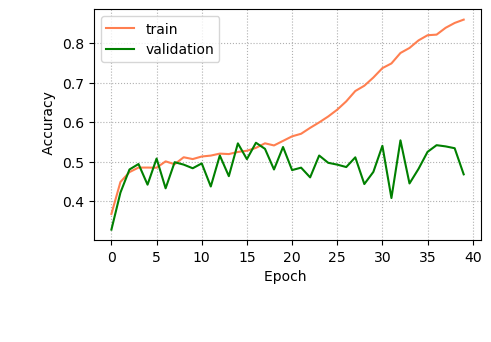

In [36]:
plt.rcdefaults()
plt.figure(figsize = (5,3))
plt.plot(accuracy_list, color = "coral", label = "train")
plt.plot(validation_accuracy_list, color = "green", label = "validation")
plt.xlabel('Epoch \n \n \n ', color = 'black')
plt.ylabel('\n \n Accuracy', color = 'black')
plt.grid(linestyle = 'dotted')
plt.legend()
experiment.log_figure(figure_name='Accuracy_plot', figure = plt)
plt.show()
plt.clf()
plt.close()

In [37]:
torch.save(best_model.state_dict(), 'C:/Users/GIB/Documents/Marta/img/trained_models/resnet.pth')

In [38]:
experiment.log_notebook('resnet.ipynb')
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/martaferpoy/vision-apnea/0832810b2848499bb63216e19d2d41f3
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Accuracy train [40]      : (0.3673704414587332, 0.8595009596928983)
COMET INFO:     Accuracy validation [40] : (0.32769230769230767, 0.5538461538461539)
COMET INFO:     Best accuracy validation : 0.54
COMET INFO:     Best kappa validation    : 0.2981271352319592
COMET INFO:     Best loss validation     : 5.820690423221123
COMET INFO:     Kappa train [40]         : (-0.0009207079075730373, 0.7854000068424948)
COMET INFO:     Kappa validation [40]    : (0.0, 0.2981271352319592)
COMET INFO:     Loss train [40]          : (2.1409170488733844, 7.292704266200072)
COMET INFO:     Loss validation [40]     : (5.486519693746799, 7.711975941774